In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt


import torch
#from torch import Tensor as tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

from scipy.integrate import odeint
from scipy.integrate import RK45


from torch.autograd.functional import jacobian



use_cuda = torch.cuda.is_available() #also worsk for AMD-ROCm
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


# Pendelum
$$\frac{d^2 \theta}{dt^2}  +  \lambda\frac{d\theta}{dt} +  \frac{g}{l}sin(\theta) $$

In [2]:
def pend(y,t,b,c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5

theta_0 = np.pi
omega_0 = 1
 
y0 = [theta_0 , omega_0]

t_final = 10

t = np.arange(0, 10, 0.01)

sol = odeint(pend,y0, t, args=(b,c))


In [3]:
theta = sol[:, 0]
omega = sol[:, 1]

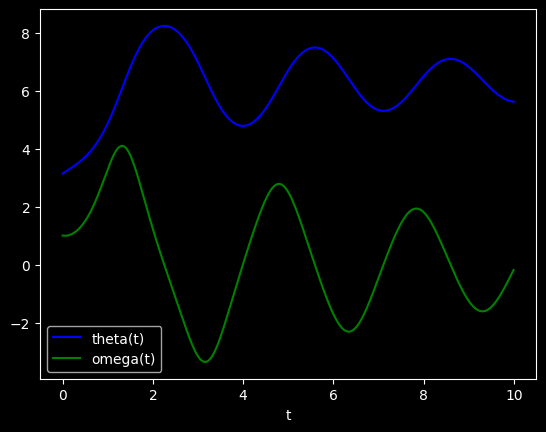

In [4]:
plt.plot(t, theta, 'b', label='theta(t)')
plt.plot(t, omega, 'g', label='omega(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.show()

# Neural ODE with ajoint-sensitivity-method

In [5]:
def euler_forward(func, x_i, t_i, t_f, delta_t, return_seq=False):
    time = torch.arange(start=t_i, end=t_f, step=delta_t, requires_grad=False)
    x = x_i.clone().detach() #makes copy of init-tensor and remvoes gradients
    #x = x_i
    if not return_seq:
        for t in time:
            #x += delta_t*func(x)
            x = x + delta_t * func(x)
        return x
    if return_seq:
        x_list = []
        for t in time:
            x = x + delta_t * func(x)
            x_list.append(x)
        return torch.tensor(x_list)

In [6]:
class ODEF(nn.Module):
    def forward_with_grad(self):
        pass
    def flatten_parameters(self):
        flat_parameters = []
        for param in self.parameters():
            flat_parameters.append(param.flatten())
        return torch.cat(flat_parameters)

In [16]:
class PendelumNetwork(ODEF):
    def __init__(self):
        super(PendelumNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 10, dtype=float),
            nn.ReLU(),
            nn.Linear(10, 10, dtype=float),
            nn.ReLU(),
            nn.Linear(10, 5, dtype=float),
            nn.ReLU(),
            nn.Linear(5, 1, dtype=float)
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

In [129]:
class PendelumFunction(ODEF):
    def __init__(self):
        super(PendelumFunction, self).__init__()
        #a*sin(b*x + c)
        
        self.a = nn.Parameter(torch.tensor(1, dtype=float))
        self.b = nn.Parameter(torch.tensor(1, dtype=float))
        self.c = nn.Parameter(torch.tensor(1, dtype=float))

    def forward(self, x):
        return self.a*torch.sin(self.b*x + self.c)


In [20]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_i, t_i, t_f, flat_parameters, func, delta_t , return_whole_seq=False):
        assert isinstance(func, ODEF)

        with torch.no_grad():
            if return_whole_seq:
                return euler_forward(func, x_i, t_i, t_f, delta_t, True)#
            else:
                output = euler_forward(func, x_i, t_i, t_f, delta_t, False)
                ctx.func = func
                ctx.save_for_backward(torch.tensor(t_f), output.clone(), flat_parameters)
                return output
        
    
    @staticmethod
    def backward(ctx, gradient):
        pass

In [14]:
class NeuralODE(nn.Module):
    def __init__(self, func, delta_t):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func
        self.delta_t = delta_t
    
    def forward(self, x_i, t_i , t_f, return_whole_seq=False):
        return ODEAdjoint.apply(x_i, t_i, t_f, self.func.flatten_parameters(), self.func, self.delta_t, return_whole_seq)
        

In [10]:
#create training and testing dataset
#input are tuples of (x_i, t_i,t_f)
#output are x_f, 
#select init and output at random

N = 100

index_input = np.random.randint(len(t), size=N)
index_output = np.random.randint(len(t), size=N)

data_set = []

for i in range(N):

    t_i = t[index_input[i]]
    t_f = t[index_output[i]]

    x_i = theta[index_input[i]]
    x_f = theta[index_output[i]]

    if t_i > t_f:
        #swap values
        t_temp = t_f
        t_f = t_i
        t_i = t_temp

        x_temp = x_f
        x_f = x_i
        x_i = x_temp

    data_set.append(((torch.tensor([x_i], requires_grad=False, dtype=float), t_i, t_f), torch.tensor([x_f],dtype=float ,requires_grad=False)))
trianing_dataset = data_set[:int(N*0.75)]
testing_dataset = data_set[int(N*0.75):]
len(trianing_dataset)

75

In [21]:
#training
epoch = 100
delta_t = 0.01
func = PendelumNetwork()
#func = PendelumFunction()
model = NeuralODE(func, delta_t)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


for k in range(epoch):
    avg_los = 0
    for i in range(len(trianing_dataset)):
        (x_i, t_i, t_f), real_value = trianing_dataset[i] 
        prediction = model(x_i, t_i, t_f)
        loss = 1/2 * (prediction - real_value)**2

        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()
        avg_los += loss.item()
        break
    if k%10==0:
        print(avg_los/len(trianing_dataset))
        prediction = model(torch.tensor([theta[0]]), 0, t[-1], True)
        plt.plot(t, theta, 'b', label='theta(t)')
        plt.plot(t[:-1],prediction)
        plt.show()


RuntimeError: function ODEAdjointBackward returned an incorrect number of gradients (expected 7, got 1)

In [123]:
for param in func.parameters():
    print(param)

Parameter containing:
tensor(1.0000, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(8.9950, dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor(0.0176, dtype=torch.float64, requires_grad=True)


In [ ]:
def one_euler_backward_step(func,x_1,delta_t):
    x = x_1.clone().detach()
    x -= delta_t * func(x)
    return x

def one_adjoint_backward_step(func, x_1, a_1, delta_t):

    a = a_1.clone().detach() 
    x = x_1.clone().detach()
    a -= delta_t * a * jacobian(func, x)

    return a



def get_gradient_with_respect_to_params(func, x):
    x = x.clone().detach()
    func(x).mean().backward()
    grads = []
    for param in func.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)
    f.zero_grad #<--- doesn't work
    return grads

def get_dL_dtheta(func, a_1, x_1, t_0, t_1, delta_t):
    time = torch.arange(start=t_0, end=t_1, step=delta_t, requires_grad=False)
    a = a_1.clone().detach() 
    x = x_1.clone().detach()
    result = torch.zeros( (a * get_gradient_with_respect_to_params(func, x)).shape)
    for t in time:
        result -= delta_t * a * get_gradient_with_respect_to_params(func, x)
        a = one_adjoint_backward_step(func, x, a, delta_t)
        x = one_euler_backward_step(func, x, delta_t)
    return result


def Loss_function(prediction):
    return (1/2  *  (theta[-1] - prediction)**2)
    

In [ ]:
x_1 = euler_forward(f, x_0, 0, t_final,delta_t, False)
x_1

tensor([3.5308], dtype=torch.float64, grad_fn=<AddBackward0>)

In [ ]:
loss = Loss_function(x_1)
loss

tensor([2.1752], dtype=torch.float64, grad_fn=<MulBackward0>)

In [ ]:
a_1 = jacobian(Loss_function, x_1)
a_1

tensor([[-2.0857]], dtype=torch.float64)

In [ ]:
get_dL_dtheta(f, a_1, x_1, 0, t_final, delta_t)

tensor([[  5182.3940,   2615.4062, -62377.1914,   3572.2505,   2093.1956,
          20063.4766,    464.5010,   1353.3417,   1707.2321,   1040.1328,
           3030.5242,   3822.8762,   1118.2527,   3258.1165,   4110.0825,
           8105.8228,  18150.9785,  19514.4199,  11215.4150,  15596.4209,
           8865.2666,  37163.9062]])

In [ ]:
for param in f.parameters():
    param.data = nn.parameter.Parameter(torch.rand_like(param))

# Sanity check-


In [ ]:
for param in f.parameters():
    print(param)

Parameter containing:
tensor([[0.2703],
        [0.6653],
        [0.0603]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.0263, 0.2417, 0.4640], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0.8103, 0.1916, 0.5303],
        [0.8317, 0.3430, 0.2151],
        [0.2263, 0.2908, 0.9295]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.3784, 0.6403, 0.1921], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([[0.4109, 0.9200, 0.9891]], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([0.0126], dtype=torch.float64, requires_grad=True)
